In [ ]:
# ==============================================================
# Step 0 — (Colab) Mount Google Drive (skip if not needed)
# ==============================================================
from google.colab import drive
drive.mount('/content/drive')

# ==============================================================
# Step 1 — Load Enron word-frequency dataset
# (Pre-vectorized CSV: first column = ID, last column = label)
# ==============================================================
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/emails.csv"
df = pd.read_csv(CSV_PATH)

print(df.shape)
print(df.columns[:10])   # preview first few columns
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(5172, 3002)
Index(['Email No.', 'the', 'to', 'ect', 'and', 'for', 'of', 'a', 'you', 'hou'], dtype='object')


,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# ==============================================================
# Step 2 — Prepare X (features) and y (label)
#  - Assumes first col is an ID, last col is the label (0/1 or 'ham'/'spam')
#  - If your label col is named (e.g., 'Prediction'), you can also select by name.
# ==============================================================
import numpy as np

# If you prefer explicit names, uncomment and set like:
# ID_COL = 'Email No.'       # change to your ID column
# LABEL_COL = 'Prediction'   # change to your label column
# X = df.drop([ID_COL, LABEL_COL], axis=1).values
# y = df[LABEL_COL].map({'ham':0,'spam':1}).fillna(df[LABEL_COL]).astype(int).values

# Generic: first col = ID, last col = label
X = df.iloc[:, 1:-1].values     # all word-frequency columns
y_raw = df.iloc[:, -1]          # last column is label (0/1 or ham/spam)

# Normalize labels to {0,1}
if y_raw.dtype == 'O':
    y = y_raw.astype(str).str.lower().map({'ham':0,'spam':1,'0':0,'1':1,'false':0,'true':1}).astype(int).values
else:
    y = y_raw.astype(int).values

spam_count = y.sum()
ham_count = len(y) - spam_count
data_spam_ratio = (spam_count/len(y)) * 100

print("Feature shape:", X.shape)
print("Label distribution:\n", pd.Series(y).value_counts())
print(f"Data ham count: {ham_count}")
print(f"Data spam count: {spam_count}")
print(f"Ratio of Ham: {100-data_spam_ratio:.3f}%")
print(f"Ratio of Spam: {data_spam_ratio:.3f}%")

Feature shape: (5172, 3000)
Label distribution:
 0    3672
1    1500
Name: count, dtype: int64
Data ham count: 3672
Ratio of Ham: 70.998%
Data spam count: 1500
Ratio of Spam: 29.002%


In [ ]:
# ==============================================================
# (Optional) Step 2.5 — Scale features for all models (same technique)
#  - MaxAbsScaler keeps non-negativity, safe for MultinomialNB.
#  - Set USE_SCALER=False if you want raw counts.
# ==============================================================
from sklearn.preprocessing import MaxAbsScaler

USE_SCALER = True  # toggle

if USE_SCALER:
    scaler = MaxAbsScaler()
    X = scaler.fit_transform(X)


In [ ]:
# ==============================================================
# Step 3 — Train/Test split (same for all)
# ==============================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (4137, 3000) Test: (1035, 3000)


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def confusion(y_test,y_pred,title, label=[0,1]):
  cm = confusion_matrix(y_test, y_pred, labels=label)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham","Spam"])
  disp.plot(cmap = "Blues")
  plt.title(f"Confusion Matrix for {title}")
  plt.show()

=== Multinomial Naive Bayes ===
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       735
           1       0.88      0.86      0.87       300

    accuracy                           0.92      1035
   macro avg       0.91      0.91      0.91      1035
weighted avg       0.92      0.92      0.92      1035

Accuracy: 0.9246376811594202


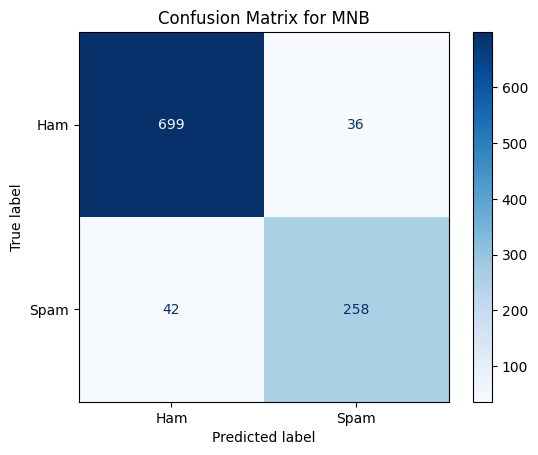

In [ ]:
# ==============================================================
# Step 4 — Baseline 1: Multinomial Naive Bayes (counts or scaled counts)
# Ref: https://github.com/MakrandBhandari/Spam-Detection-using-Multinomial-Naive-Bayes-Classifier
# ==============================================================
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

nb = MultinomialNB(alpha=1.0)
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("=== Multinomial Naive Bayes ===")
print(classification_report(y_test, y_pred_nb, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
confusion(y_test,y_pred_nb,title = "MNB")

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       735
           1       0.96      0.94      0.95       300

    accuracy                           0.97      1035
   macro avg       0.97      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035

Accuracy: 0.970048309178744


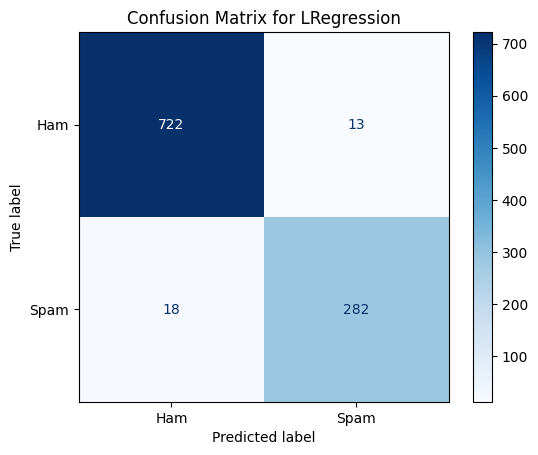

In [ ]:
# ==============================================================
# Step 5 — Baseline 2: Logistic Regression (linear model for text)
# Ref: https://github.com/Ananya01Agrawal/Spam-Mail-Detection-using-TF-IDF
# Notes: use solver='saga', larger max_iter for convergence on sparse/high-dim data.
# ==============================================================
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    solver="saga", penalty="l2", C=1.0,
    max_iter=5000, n_jobs=-1, random_state=42
)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
confusion(y_test,y_pred_lr,title = "LRegression")

=== Linear SVM ===
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       735
           1       0.93      0.98      0.95       300

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035

Accuracy: 0.9719806763285024


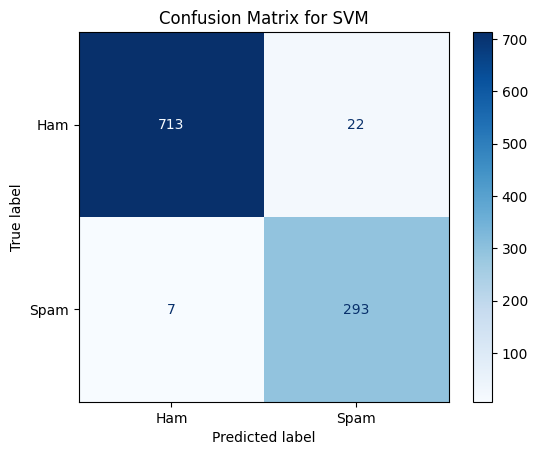

In [ ]:
# ==============================================================
# Step 6 — Baseline 3: Linear SVM
# Ref: https://github.com/sidghimire/Email-Spam-Detection-SVM
# ==============================================================
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1.0, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("=== Linear SVM ===")
print(classification_report(y_test, y_pred_svm, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
confusion(y_test,y_pred_svm,title = "SVM")

,model,accuracy,precision,recall,f1
0,Naive Bayes,0.924638,0.877551,0.860000,0.868687
1,Logistic Regression,0.970048,0.955932,0.940000,0.947899
2,Linear SVM,0.971981,0.930159,0.976667,0.952846


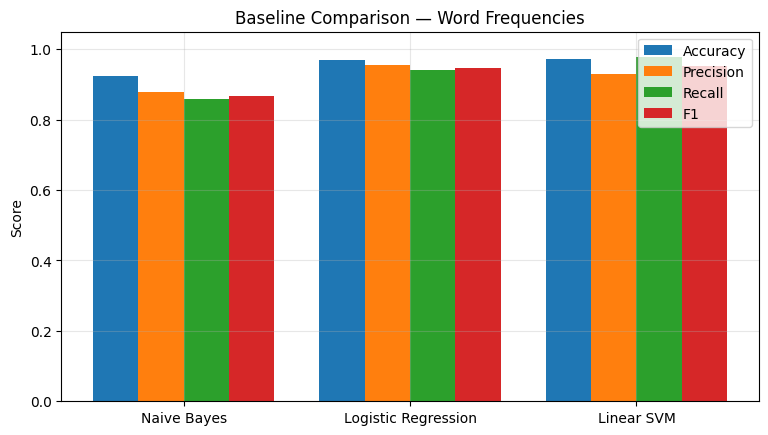

In [ ]:
# ==============================================================
# Step 7 — Metrics table + comparison bar chart
# ==============================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

def summarize(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    return dict(model=name, accuracy=acc, precision=p, recall=r, f1=f1)

res = [
    summarize("Naive Bayes", y_test, y_pred_nb),
    summarize("Logistic Regression", y_test, y_pred_lr),
    summarize("Linear SVM", y_test, y_pred_svm),
]
res_df = pd.DataFrame(res)
display(res_df)

# Bar chart
x = np.arange(len(res_df))
plt.figure(figsize=(9,4.8))
plt.bar(x-0.3, res_df['accuracy'], width=0.2, label='Accuracy')
plt.bar(x-0.1, res_df['precision'], width=0.2, label='Precision')
plt.bar(x+0.1, res_df['recall'], width=0.2, label='Recall')
plt.bar(x+0.3, res_df['f1'], width=0.2, label='F1')
plt.xticks(x, res_df['model'])
plt.ylim(0, 1.05)
plt.title("Baseline Comparison — Word Frequencies")
plt.ylabel("Score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


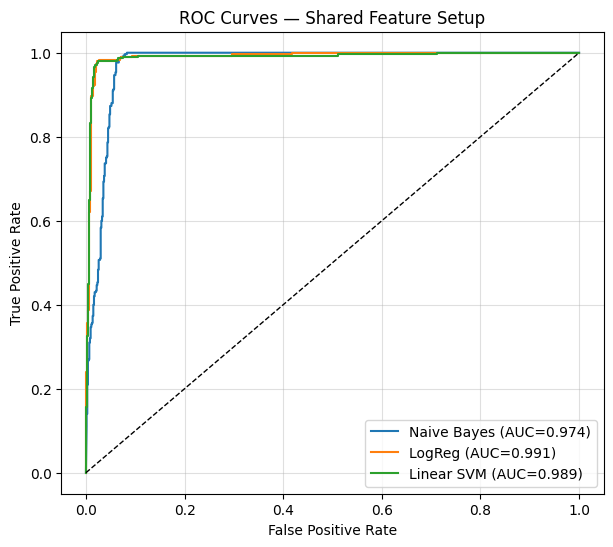

In [ ]:
# ==============================================================
# Step 8 — ROC Curves (NB & LR via predict_proba; SVM via decision_function)
#  - If your SVM has no decision_function on this input, we skip its ROC.
# ==============================================================
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

lb = LabelBinarizer().fit(y_test)
y_true_bin = lb.transform(y_test)

plt.figure(figsize=(7,6))

# NB
try:
    nb_proba = nb.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_true_bin, nb_proba)
    plt.plot(fpr, tpr, label=f"Naive Bayes (AUC={auc(fpr,tpr):.3f})")
except Exception as e:
    print("NB ROC skipped:", e)

# LR
try:
    lr_proba = lr.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_true_bin, lr_proba)
    plt.plot(fpr, tpr, label=f"LogReg (AUC={auc(fpr,tpr):.3f})")
except Exception as e:
    print("LR ROC skipped:", e)

# SVM
try:
    svm_scores = svm.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_true_bin, svm_scores)
    plt.plot(fpr, tpr, label=f"Linear SVM (AUC={auc(fpr,tpr):.3f})")
except Exception as e:
    print("SVM ROC skipped:", e)

plt.plot([0,1],[0,1],'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Shared Feature Setup")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Re-use X_test, y_test, nb, lr, svm from earlier
rng = np.random.RandomState(42)

def drop_words(X, drop_prob=0.1):
    """Randomly set a fraction of word counts to 0 (simulating missing tokens)."""
    Xn = X.copy().astype(np.float32)
    mask = rng.rand(*Xn.shape) < drop_prob
    Xn[mask] = 0
    return Xn

def add_noise(X, noise_rate=0.05, max_inflate=2):
    """Randomly add small integer noise to some positions (simulating typos or extra words)."""
    Xn = X.copy().astype(np.int32)
    mask = rng.rand(*Xn.shape) < noise_rate
    noise = rng.randint(0, max_inflate + 1, size=Xn.shape)
    Xn = Xn + (mask * noise)
    return Xn

def evaluate_noise(model, X_clean, y_true, label):
    y_pred = model.predict(X_clean)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{label:<28}  Accuracy={acc:.4f}  F1={f1:.4f}")

# Create noisy variants
X_drop10 = drop_words(X_test, drop_prob=0.10)
X_noise5 = add_noise(X_test, noise_rate=0.05, max_inflate=2)
X_both = add_noise(drop_words(X_test, 0.10), noise_rate=0.05, max_inflate=2)

print("==== Baseline (clean data) ====")
evaluate_noise(nb, X_test, y_test, "Naive Bayes clean")
evaluate_noise(lr, X_test, y_test, "Logistic Regression clean")
evaluate_noise(svm, X_test, y_test, "Linear SVM clean")

print("\n==== With 10% word-drop ====")
evaluate_noise(nb, X_drop10, y_test, "Naive Bayes (drop10%)")
evaluate_noise(lr, X_drop10, y_test, "Logistic Regression (drop10%)")
evaluate_noise(svm, X_drop10, y_test, "Linear SVM (drop10%)")

print("\n==== With 5% additive noise ====")
evaluate_noise(nb, X_noise5, y_test, "Naive Bayes (+5% noise)")
evaluate_noise(lr, X_noise5, y_test, "Logistic Regression (+5% noise)")
evaluate_noise(svm, X_noise5, y_test, "Linear SVM (+5% noise)")

print("\n==== Combined (drop + noise) ====")
evaluate_noise(nb, X_both, y_test, "Naive Bayes (combined)")
evaluate_noise(lr, X_both, y_test, "Logistic Regression (combined)")
evaluate_noise(svm, X_both, y_test, "Linear SVM (combined)")


==== Baseline (clean data) ====
Naive Bayes clean             Accuracy=0.9246  F1=0.8687
Logistic Regression clean     Accuracy=0.9536  F1=0.9248
Linear SVM clean              Accuracy=0.9614  F1=0.9363

==== With 10% word-drop ====
Naive Bayes (drop10%)         Accuracy=0.9179  F1=0.8542
Logistic Regression (drop10%)  Accuracy=0.9459  F1=0.9133
Linear SVM (drop10%)          Accuracy=0.9585  F1=0.9319

==== With 5% additive noise ====
Naive Bayes (+5% noise)       Accuracy=0.5546  F1=0.4357
Logistic Regression (+5% noise)  Accuracy=0.6638  F1=0.2197
Linear SVM (+5% noise)        Accuracy=0.6831  F1=0.1961

==== Combined (drop + noise) ====
Naive Bayes (combined)        Accuracy=0.5043  F1=0.3886
Logistic Regression (combined)  Accuracy=0.6502  F1=0.2298
Linear SVM (combined)         Accuracy=0.6696  F1=0.1699
